# Model prototype

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [153]:
# Constants
class const:
    N_BOTS = 50 # Starting numbers
    N_BOTS_MAX = 500 # Hard threshold on max number of bots, for performance purposes
    MAX_ITERATIONS = 3000
    INTERACTION_DISTANCE = 0.02
    FOOD_VALUE = 10
    START_HEALTH = 10
    BIRTH_HEALTH = 10
    REPRODUCTIVE_COST = 11 # Each parent pays it
    GROW_PERIOD = 3
    BOT_SPEED = 0.02
    MOVING_COST = 0.08 # Health per distance

const = const()

In [154]:
class bot:
    def __init__(self,xy=[],health=const.START_HEALTH):
        if len(xy)==0:
            self.xy = np.random.rand(2)
        else:
            self.xy = xy
        self.speed = const.BOT_SPEED
        self.health = health
        
    def move(self):
        v = np.random.normal(size=2)
        v = v/np.linalg.norm(v)*self.speed
        self.xy = np.minimum(1,np.maximum(0,self.xy+v))
        self.health -= const.MOVING_COST

In [155]:
class bots:
    def __init__(self,n=100):
        self.bots = list()
        self.distances = np.zeros(n)
        for i in range(n):
            self.bots.append(bot())
        self.update_distances()
        
    def update_distances(self):
        xy = np.array([b.xy for b in self.bots])
        self.distances = (xy[:,0,np.newaxis]-xy[np.newaxis,:,0])**2 + (xy[:,1,np.newaxis]-xy[np.newaxis,:,1])**2
            
    def move(self):
        for i in range(len(self.bots)):
            self.bots[i].move()
    
    def die(self):
        if len(self.bots) > const.N_BOTS_MAX:
            self.bots = self.bots[0:const.N_BOTS_MAX]
        for i in range(len(self.bots)-1,-1,-1):
            if self.bots[i].health<0:
                del self.bots[i]
        
    def distance(self,i,j): 
        #return np.linalg.norm(self.bots[i].xy-self.bots[j].xy)
        #return sum(abs(self.bots[i].xy-self.bots[j].xy))
        return self.distances[i,j]
        
    def procreate(self):
        newBots = []
        for i in range(1,len(self.bots)):
            for j in range(i):
                if (self.distance(i,j) < const.INTERACTION_DISTANCE**2 and
                    self.bots[i].health > const.REPRODUCTIVE_COST and
                    self.bots[j].health > const.REPRODUCTIVE_COST):
                        
                    self.bots[i].health -= const.REPRODUCTIVE_COST
                    self.bots[j].health -= const.REPRODUCTIVE_COST
                    newBots.append(bot(health=const.BIRTH_HEALTH , xy=self.bots[i].xy))
        self.bots += newBots
                    
    def eat(self,food):
        for i in range(1,len(self.bots)):
            del_list = []
            for j in range(food.xy.shape[0]):
                if np.linalg.norm(self.bots[i].xy - food.xy[j,:]) < const.INTERACTION_DISTANCE:
                    self.bots[i].health += const.FOOD_VALUE
                    self.bots[i].xy = food.xy[j,:]
                    del_list.append(j)
            food.xy = np.delete(food.xy, del_list, axis=0) # This food is now eaten

In [156]:
class food_class:
    def __init__(self,n=50):
        self.xy = np.random.rand(n,2)
        
    def grow(self,count):
        if count % const.GROW_PERIOD == 0:
            self.xy = np.vstack((self.xy , np.random.rand(1,2)))

In [157]:
def draw_food(a,xy):
    if len(a.lines)==0:
        a.plot(xy[:,0],xy[:,1],'.g')
    else:
        a.lines[0].set_xdata(xy[:,0])
        a.lines[0].set_ydata(xy[:,1])
        
def draw_animals(a,xy,clr):
    if len(a.collections)==0:
        a.scatter(xy[:,0],xy[:,1],c=clr,vmin=-1, vmax=100)
    else:
        a.collections[0].set_offsets(xy)
        a.collections[0].set_array(clr)
        
def draw_graph(a,y):
    '''Update the population graph on the right with a new number'''
    if len(a.lines)==0:
        a.plot([1],y,'-')
        #a.autoscale(enable=True)
    else:
        r = len(history)
        l = max(0,r-400)
        a.lines[0].set_xdata(list(range(l,r)))
        a.lines[0].set_ydata(history[l:r])
        a.set_xlim(l,r)
        a.set_ylim(0,max(a.get_ylim()[1],history[-1]))

<IPython.core.display.Javascript object>


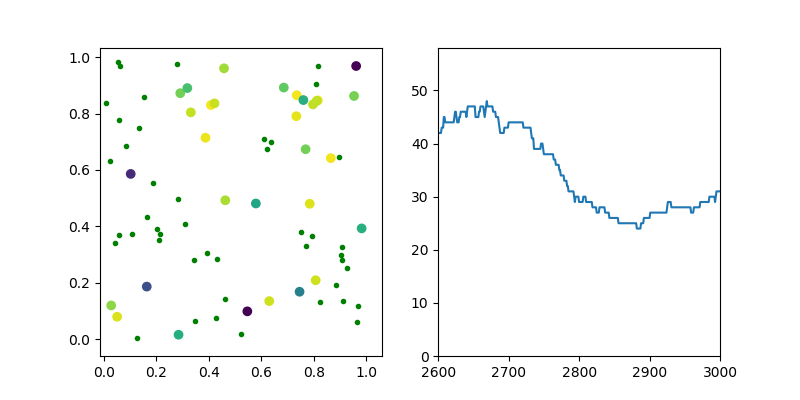

start
stop. Time: 139.07


In [158]:
%matplotlib notebook
# This comment above is necessary; without it it doesn't render eagerly, so no animations

b1 = bots(const.N_BOTS)
food = food_class()

#a1 = plt.axes()
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
tic = time.time()
print('start')

count = 0
history = []
while count < const.MAX_ITERATIONS:
    if len(b1.bots)==0:
        print('All dead')
        break
    food.grow(count)
    b1.move()
    b1.eat(food)
    b1.update_distances()
    b1.procreate()
    b1.die()
    history.append(len(b1.bots))
    
    animals_xy = np.array([b.xy for b in b1.bots])
    animals_clr = 100-np.array([b.health for b in b1.bots])
    draw_food(ax1, food.xy)
    draw_animals(ax1, animals_xy, animals_clr)
    draw_graph(ax2,history)
    fig.canvas.draw()
    count += 1
print('stop. Time:', round(time.time()-tic , ndigits=2))

<IPython.core.display.Javascript object>


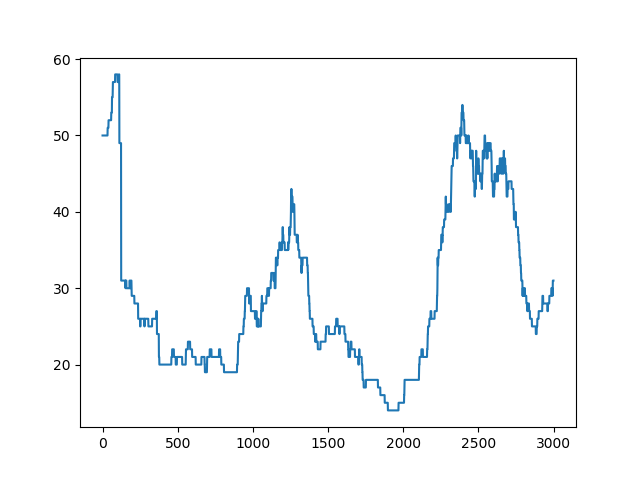

In [159]:
plt.figure()
plt.plot(history);